In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import SpectralToolbox.Spectral1D as S1D
import TransportMaps as TM
import TransportMaps.Functionals as FUNC
import TransportMaps.Maps as MAPS
%matplotlib inline
TM.setLogLevel(logging.INFO)

# Inverse transport

Let $\{x_i\}_{i=1}^\infty$ be a Monte-Carlo sample of a random variable $X$ with **unknown distribution** $\nu_\pi$. Our goal is to characterize this distribution, given a finite sample $\{x_i\}_{i=1}^n$ from $X$.
We then look for the map $\hat{S}$ such that

$$
\hat{S} = \arg\min_{S\in\mathcal{T}_\triangle} \mathcal{D}_{\rm KL}
\left( S_\sharp \nu_\pi \middle\Vert \nu_\rho \right) \;,
$$

where $\nu_\rho$ is the distribution $\mathcal{N}(0,1)$.

For the sake of this sythetic example we enforce $X\sim \text{Gumbel}(\mu, \beta)$, with $\mu=3$ and $\beta=4$. Let us then construct the [Distribution](api-TransportMaps-Distributions.html#TransportMaps.Distributions.Distribution) $\nu_\pi$, for which we are only able to define its (Monte-Carlo) quadrature method (note that in the [inference](examples-direct-transport.html) case we instead defined its density).

In [44]:
import TransportMaps.Distributions as DIST

class GumbelDistribution(DIST.Distribution):
    def __init__(self, mu, beta):
        super(GumbelDistribution,self).__init__(1)
        self.mu = mu
        self.beta = beta
        self.dist = stats.gumbel_r(loc=mu, scale=beta)
    def quadrature(self, qtype, qparams, *args, **kwargs):
        if qtype == 0: # Monte-Carlo
            x = self.dist.rvs(qparams)[:,np.newaxis]
            w = np.ones(qparams)/float(qparams)
        else: raise ValueError("Quadrature not defined")
        return (x, w)

mu = 3.
beta = 4.
pi = GumbelDistribution(mu,beta)

We can then generate and visualize a finite sample...

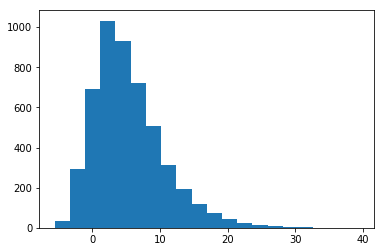

In [45]:
x, w = pi.quadrature(0, 5000)
plt.figure()
plt.hist(x, bins=20);

For the sake of the example, let us define the complete Gumbel distributions (including its pdf)

In [46]:
class GumbelDistribution(DIST.Distribution):
    def __init__(self, mu, beta):
        super(GumbelDistribution,self).__init__(1)
        self.mu = mu
        self.beta = beta
        self.dist = stats.gumbel_r(loc=mu, scale=beta)
    def pdf(self, x, params=None):
        return self.dist.pdf(x).flatten()
    def quadrature(self, qtype, qparams, *args, **kwargs):
        if qtype == 0: # Monte-Carlo
            x = self.dist.rvs(qparams)[:,np.newaxis]
            w = np.ones(qparams)/float(qparams)
        else: raise ValueError("Quadrature not defined")
        return (x, w)
pi = GumbelDistribution(mu,beta)

Let us also define the exact transport $S^\star$ such that $S^\star_\sharp \nu_\pi = \nu_\rho$ ...

In [9]:
class GumbelTransportMap(object):
    def __init__(self, mu, beta):
        self.ref = stats.gumbel_r(loc=mu, scale=beta)
        self.tar = stats.norm(0.,1.)
    def evaluate(self, x, params=None):
        if isinstance(x,float):
            x = np.array([[x]])
        if x.ndim == 1:
            x = x[:,NAX]
        out = self.tar.ppf( self.ref.cdf(x) )
        return out
    def __call__(self, x):
        return self.evaluate(x)
Sstar = GumbelTransportMap(mu,beta)

Let us visualize $S^\star$ and its application on $\nu_\pi$ ...

In [84]:
x_tm = np.linspace(-6,40,100).reshape((100,1))
def plot_mapping(pi_star, Sstar, pi=None, S=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax_twx = ax.twinx()
    ax_twy = ax.twiny()
    ax.plot(x_tm, Sstar(x_tm), 'k-', label=r"$S^\star$") # Map
    n01, = ax_twx.plot(x_tm, pi_star.pdf(x_tm), '-b') # Gumbel
    g, = ax_twy.plot(
        stats.norm(0,1).pdf(Sstar(x_tm)), Sstar(x_tm), '-r') # N(0,1)
    if S is not None:
        ax.plot(x_tm, S(x_tm), 'k--', label=r"$\hat{S}$") # Map
    if pi is not None:
        ax_twx.plot(x_tm, pi.pdf(x_tm), '--b') # Gumbel
    ax.set_ylabel(r"Map")
    ax_twx.set_ylabel('Gumbel')
    ax_twx.yaxis.label.set_color(n01.get_color())
    ax_twy.set_xlabel('N(0,1)')
    ax_twy.xaxis.label.set_color(g.get_color())
    ax.legend(loc = (0.8, 0.15))

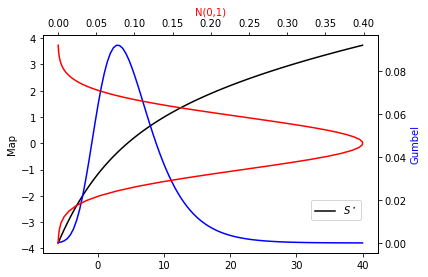

In [85]:
plot_mapping(pi, Sstar)

## Variational solution

Before setting out to solve the problem, we need to first try to rescale the distribution $\nu_\pi$ so that most of its mass is around the bulk of $\nu_\rho$. We do this because polynomial approximations (which we use for the parametrization of $S$) are mostly accurate around 0. This step can be easily carried out using the finite sample $\{x_i\}_{i=1}^n$ (i.e. we don't need to evaluate $\pi$). We then define the linear map $L$ that maps $\{x_i\}_{i=1}^n$ to the interval (e.g.) $[-4,4]$.

In [71]:
xmax = np.max(x)
xmin = np.min(x)
a = np.array([ 4*(xmin+xmax)/(xmin-xmax) ])
b = np.array([ 8./(xmax-xmin) ])
L = MAPS.FrozenLinearDiagonalTransportMap(a,b)

Let us check this transformation on the sample $\{x_i\}_{i=1}^n$ ...

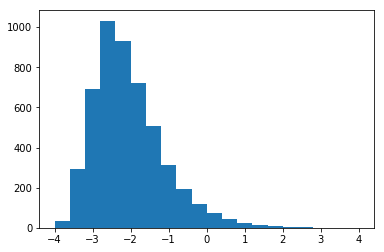

In [72]:
plt.figure()
plt.hist(L(x), bins=20);

Let us then set up the variational problem

$$
\hat{S} = \arg\min_{S\in\mathcal{T}_\triangle} \mathcal{D}_{\rm KL}
\left( S_\sharp L_\sharp \nu_\pi \middle\Vert \nu_\rho \right) \;,
$$

where we define $\mathcal{T}_\triangle$ to be the set of [integrated squared triangular transport maps](api-TransportMaps-Maps.html#TransportMaps.Maps.IntegratedSquaredTriangularTransportMap) (presented [here](example-gumbel-1d.html#Integrated-squared-parametrization)) of (total) order 3.

In [73]:
S = TM.Default_IsotropicIntegratedSquaredTriangularTransportMap(
    1, 3, 'total')
rho = DIST.StandardNormalDistribution(1)
push_L_pi = DIST.PushForwardTransportMapDistribution(L, pi)
push_SL_pi = DIST.PushForwardTransportMapDistribution(
    S, push_L_pi)
qtype = 0      # Monte-Carlo quadratures from pi
qparams = 500  # Number of MC points
reg = None     # No regularization
tol = 1e-3     # Optimization tolerance
ders = 2       # Use gradient and Hessian 
log = push_SL_pi.minimize_kl_divergence(
    rho, qtype=qtype, qparams=qparams, regularization=reg,
    tol=tol, ders=ders)

2017-04-15 17:35:32 INFO: IntegratedSquaredTriangularTransportMap: Optimization terminated successfully
2017-04-15 17:35:32 INFO: IntegratedSquaredTriangularTransportMap:   Function value:          1.249192
2017-04-15 17:35:32 INFO: IntegratedSquaredTriangularTransportMap:   Norm of the Jacobian:    0.000420
2017-04-15 17:35:32 INFO: IntegratedSquaredTriangularTransportMap:   Number of iterations:         9
2017-04-15 17:35:32 INFO: IntegratedSquaredTriangularTransportMap:   N. function evaluations:     10
2017-04-15 17:35:32 INFO: IntegratedSquaredTriangularTransportMap:   N. Jacobian evaluations:     18
2017-04-15 17:35:32 INFO: IntegratedSquaredTriangularTransportMap:   N. Hessian evaluations:       9


We can now check the accuracy of $L^\sharp \hat{S}^\sharp \rho \approx \pi$ ...

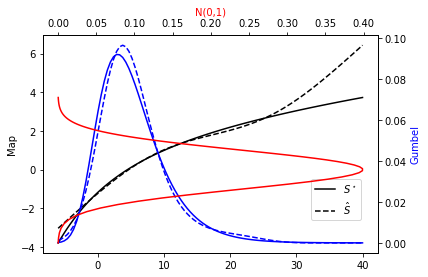

In [86]:
SL = MAPS.CompositeTransportMap(S,L)
pull_SL_rho = DIST.PullBackTransportMapDistribution(SL, rho)
plot_mapping(pi, Sstar, pull_SL_rho, SL)